In [2]:
# Setup
import time
import numpy as np
import matplotlib.pyplot as plt
from builtins import range
from builtins import object
from __future__ import print_function, division
from future import standard_library
standard_library.install_aliases()
from six.moves import cPickle as pickle
from past.builtins import xrange
from random import randrange
import os
#import pickle as pickle
import platform

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # Set default size of plots.
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Some Useful Functions for Forward and Backward passes

In [5]:
def affine_forward(x, w, b):
    """Computes the forward pass for an affine (fully connected) layer.

    The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N examples, where each example x[i] has shape (d_1, ..., d_k). We will
    reshape each input into a vector of dimension D = d_1 * ... * d_k, and then transform it to an output vector of dimension M.

    Inputs:
    - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
    - w: A numpy array of weights, of shape (D, M)
    - b: A numpy array of biases, of shape (M,)

    Returns a tuple of:
    - out: output, of shape (N, M)
    - cache: (x, w, b)
    """
    out = None
    
    x_row = x.reshape(x.shape[0], -1) #shape (N, D)
    
    out = x_row@w + b #shape (N, M)
    cache = (x, w, b)
    
    return out, cache

def affine_backward(dout, cache):
    """Computes the backward pass for an affine (fully connected) layer.

    Inputs:
    - dout: Upstream derivative, of shape (N, M)
    - cache: Tuple of:
      - x: Input data, of shape (N, d_1, ... d_k)
      - w: Weights, of shape (D, M)
      - b: Biases, of shape (M,)

    Returns a tuple of:
    - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
    - dw: Gradient with respect to w, of shape (D, M)
    - db: Gradient with respect to b, of shape (M,)
    """
    x, w, b = cache
    dx, dw, db = None, None, None

    x_row = x.reshape(x.shape[0], -1) #shape (N, D)
    dw = x_row.T@dout
    db = np.sum(dout, axis=0)
    dx = (dout@w.T).reshape(x.shape[0], *x.shape[1:])

    return dx, dw, db

def relu_forward(x):
    """Computes the forward pass for a layer of rectified linear units (ReLUs).

    Input:
    - x: Inputs, of any shape

    Returns a tuple of:
    - out: Output, of the same shape as x
    - cache: x
    """
    out = None

    out = np.maximum(0, x)
    cache = x
    
    return out, cache

def relu_backward(dout, cache):
    """Computes the backward pass for a layer of rectified linear units (ReLUs).

    Input:
    - dout: Upstream derivatives, of any shape
    - cache: Input x, of same shape as dout

    Returns:
    - dx: Gradient with respect to x
    """
    dx, x = None, cache
    dx = dout*(x > 0)

    return dx

def softmax_loss(x, y):
    """Computes the loss and gradient for softmax classification.

    Inputs:
    - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class for the ith input.
    - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and 0 <= y[i] < C

    Returns a tuple of:
    - loss: Scalar giving the loss
    - dx: Gradient of the loss with respect to x
    """
    loss, dx = None, None

    num_train = x.shape[0]
    num_classes = x.shape[1]
    fs = x     
    fs = fs - fs.max(axis = 1, keepdims = True) #exponents that are numerically stable
    probs = np.exp(fs)/np.sum(np.exp(fs), axis = 1, keepdims = True)
    loss = -np.sum(np.log(probs[range(num_train), y]))
    loss = loss/num_train

    probs[range(num_train), y] -= 1
    dx = probs/num_train

    return loss, dx

def batchnorm_forward(x, gamma, beta, bn_param):
    """Forward pass for batch normalization.

    During training the sample mean and (uncorrected) sample variance are computed from minibatch statistics and used to normalize the incoming data.
    During training we also keep an exponentially decaying running mean of the mean and variance of each feature, and these averages are used to normalize data at test-time.

    At each timestep we update the running averages for mean and variance using an exponential decay based on the momentum parameter:
    running_mean = momentum * running_mean + (1 - momentum) * sample_mean
    running_var = momentum * running_var + (1 - momentum) * sample_var

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - bn_param: Dictionary with the following keys:
      - mode: 'train' or 'test'; required
      - eps: Constant for numeric stability
      - momentum: Constant for running mean / variance.
      - running_mean: Array of shape (D,) giving running mean of features
      - running_var Array of shape (D,) giving running variance of features

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    mode = bn_param["mode"]
    eps = bn_param.get("eps", 1e-5)
    momentum = bn_param.get("momentum", 0.9)

    N, D = x.shape
    running_mean = bn_param.get("running_mean", np.zeros(D, dtype=x.dtype))
    running_var = bn_param.get("running_var", np.zeros(D, dtype=x.dtype))

    out, cache = None, None
    if mode == "train":
        mu = x.mean(axis=0)        # batch mean for each feature
        var = x.var(axis=0)        
        std = np.sqrt(var + eps)   # batch standard deviation for each feature
        x_hat = (x - mu) / std     # standartized x
        out = gamma * x_hat + beta # scaled and shifted x_hat

        shape = bn_param.get('shape', (N, D))              # reshape used in backprop
        axis = bn_param.get('axis', 0)                     # axis to sum used in backprop
        cache = x, mu, var, std, gamma, x_hat, shape, axis 

        if axis == 0:                                                    
            running_mean = momentum * running_mean + (1 - momentum) * mu # update overall mean
            running_var = momentum * running_var + (1 - momentum) * var  # update overall variance

    elif mode == "test":
        
        x_hat = (x - running_mean) / np.sqrt(running_var + eps)
        out = gamma * x_hat + beta

    else:
        raise ValueError('Invalid forward batchnorm mode "%s"' % mode)

    # Store the updated running means back into bn_param
    bn_param["running_mean"] = running_mean
    bn_param["running_var"] = running_var

    return out, cache

def batchnorm_backward(dout, cache):
    """Backward pass for batch normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from batchnorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None
    
    # original paper (https://arxiv.org/abs/1502.03167)
    # https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html
    
    x, mu, var, std, gamma, x_hat, shape, axis = cache          # expand cache

    dbeta = dout.reshape(shape, order='F').sum(axis)            # derivative w.r.t. beta
    dgamma = (dout * x_hat).reshape(shape, order='F').sum(axis) # derivative w.r.t. gamma

    dx_hat = dout * gamma                                       # derivative w.r.t. x_hat
    dstd = -np.sum(dx_hat * (x-mu), axis=0) / (std**2)          # derivative w.r.t. std
    dvar = 0.5 * dstd / std                                     # derivative w.r.t. var
    dx1 = dx_hat / std + 2 * (x-mu) * dvar / len(dout)          # partial derivative w.r.t. dx
    dmu = -np.sum(dx1, axis=0)                                  # derivative w.r.t. mu
    dx2 = dmu / len(dout)                                       # partial derivative w.r.t. dx
    dx = dx1 + dx2                                              # full derivative w.r.t. x

    return dx, dgamma, dbeta


def batchnorm_backward_alt(dout, cache):
    """Alternative backward pass for batch normalization.

    Inputs / outputs: Same as batchnorm_backward
    """
    dx, dgamma, dbeta = None, None, None

    _, _, _, std, gamma, x_hat, shape, axis = cache
    S = lambda x: x.sum(axis=0)                     # helper function
    
    dbeta = dout.reshape(shape, order='F').sum(axis)            # derivative w.r.t. beta
    dgamma = (dout * x_hat).reshape(shape, order='F').sum(axis) # derivative w.r.t. gamma
    
    dx = dout * gamma / (len(dout) * std)          # temporarily initialize scale value
    dx = len(dout)*dx  - S(dx*x_hat)*x_hat - S(dx) # derivative w.r.t. unnormalized x

    return dx, dgamma, dbeta


def layernorm_forward(x, gamma, beta, ln_param):
    """Forward pass for layer normalization.

    During both training and test-time, the incoming data is normalized per data-point, before being scaled by gamma and beta parameters identical to that of batch normalization.

    In contrast to batch normalization, the behavior during train and test-time for layer normalization are identical, and we do not need to keep track of running averages of any sort.

    Input:
    - x: Data of shape (N, D)
    - gamma: Scale parameter of shape (D,)
    - beta: Shift paremeter of shape (D,)
    - ln_param: Dictionary with the following keys:
        - eps: Constant for numeric stability

    Returns a tuple of:
    - out: of shape (N, D)
    - cache: A tuple of values needed in the backward pass
    """
    out, cache = None, None
    eps = ln_param.get("eps", 1e-5)

    mu = x.mean(axis=1)        # mean for each example; dims (N,)
    var = x.var(axis=1)        
    std = np.sqrt(var + eps)   # standard deviation for each example; dims (N,)
    x_hat = (x.T - mu) / std    # standartized x; dims (D, N)
    out = gamma * x_hat.T + beta # scaled and shifted x_hat; dims (N, D)

    N, D = x.shape
    shape = (D, N)
    axis = 1

    cache = x.T, mu, var, std, np.atleast_2d(gamma).T, x_hat, shape, axis
    
    return out, cache


def layernorm_backward(dout, cache):
    """Backward pass for layer normalization.

    Inputs:
    - dout: Upstream derivatives, of shape (N, D)
    - cache: Variable of intermediates from layernorm_forward.

    Returns a tuple of:
    - dx: Gradient with respect to inputs x, of shape (N, D)
    - dgamma: Gradient with respect to scale parameter gamma, of shape (D,)
    - dbeta: Gradient with respect to shift parameter beta, of shape (D,)
    """
    dx, dgamma, dbeta = None, None, None

    dx, dgamma, dbeta = batchnorm_backward_alt(dout.T, cache)
    dx = dx.T                                                 # transpose back dx

    return dx, dgamma, dbeta


def dropout_forward(x, dropout_param):
    """Forward pass for inverted dropout.

    different from the vanilla version of dropout.
    Here, p is the probability of keeping a neuron output, as opposed to the probability of dropping a neuron output.

    Inputs:
    - x: Input data, of any shape
    - dropout_param: A dictionary with the following keys:
      - p: Dropout parameter. We keep each neuron output with probability p.
      - mode: 'test' or 'train'. If the mode is train, then perform dropout;
        if the mode is test, then just return the input.
      - seed: Seed for the random number generator. Passing seed makes this
        function deterministic, which is needed for gradient checking but not
        in real networks.

    Outputs:
    - out: Array of the same shape as x.
    - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
      mask that was used to multiply the input; in test mode, mask is None.
    """
    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        mask = np.random.choice([0, 1], size=x.shape, p=[1-p, p])/p
        out = x*mask

    elif mode == "test":
        out = x
    
    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache


def dropout_backward(dout, cache):
    """Backward pass for inverted dropout.

    Inputs:
    - dout: Upstream derivatives, of any shape
    - cache: (dropout_param, mask) from dropout_forward.
    """
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        dx = dout*mask

    elif mode == "test":
        dx = dout
    return dx

def affine_relu_forward(x, w, b):
    """Convenience layer that performs an affine transform followed by a ReLU.

    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer

    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = affine_forward(x, w, b)
    out, relu_cache = relu_forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

def affine_relu_backward(dout, cache):
    """Backward pass for the affine-relu convenience layer.
    """
    fc_cache, relu_cache = cache
    da = relu_backward(dout, relu_cache)
    dx, dw, db = affine_backward(da, fc_cache)
    return dx, dw, db

def generic_forward(x, w, b, gamma=None, beta=None, bn_param=None, dropout_param=None, last=False):
    """Convenience layer that performs an affine transform, a batch/layer normalization if needed, a ReLU, and dropout if needed.
    
    Inputs:
    - x: Input to the affine layer
    - w, b: Weights for the affine layer
    - gamma, beta: Scale and shift params for the batch normalization
    - bn_param: Dictionary of required BN parameters
    - dropout_param: Dictionary of required Dropout parameters
    - last: Indicates wether to perform just affine forward
    Returns a tuple of:
    - out: Output from the ReLU or Dropout
    - cache: Object to give to the backward pass
    """
    
    bn_cache, ln_cache, relu_cache, dropout_cache = None, None, None, None # Initialize optional caches to None
    out, fc_cache = affine_forward(x, w, b) # Affine forward is a must

    # If the the layer is not last
    if not last:
        # If it has normalization layer we normalize outputs: if it bn_param has mode (train | test), it's batchnorm, otherwise, it's layernorm
        if bn_param is not None:
            if 'mode' in bn_param:
                out, bn_cache = batchnorm_forward(out, gamma, beta, bn_param)
            else:
                out, ln_cache = layernorm_forward(out, gamma, beta, bn_param)

        # Pass the outputs through non-linearity
        out, relu_cache = relu_forward(out) # perform relu

        # Use dropout if we are given its parameters
        if dropout_param is not None:
            out, dropout_cache = dropout_forward(out, dropout_param)
    
    # Prepare cache for backward pass
    cache = fc_cache, bn_cache, ln_cache, relu_cache, dropout_cache

    return out, cache

def generic_backward(dout, cache):
    """Backward pass for the affine-bn/ln?-relu-dropout? convenience layer.
    """
    # Init norm params to None
    dgamma, dbeta = None, None

    # Get the prapared caches from the forward pass
    fc_cache, bn_cache, ln_cache, relu_cache, dropout_cache = cache

    # If dropout was performed
    if dropout_cache is not None:
        dout = dropout_backward(dout, dropout_cache)
    
    # If relu was performed
    if relu_cache is not None:
        dout = relu_backward(dout, relu_cache)

    # If norm was performed
    if bn_cache is not None:
        dout, dgamma, dbeta = batchnorm_backward(dout, bn_cache)
    elif ln_cache is not None:
        dout, dgamma, dbeta = layernorm_backward(dout, ln_cache)
    
    # Affine backward is a must
    dx, dw, db = affine_backward(dout, fc_cache)

    return dx, dw, db, dgamma, dbeta

# Objects for Defining Neural Network

In [6]:
class FullyConnectedNet(object):
    """Class for a multi-layer fully connected neural network.

    Network contains an arbitrary number of hidden layers, ReLU nonlinearities,
    and a softmax loss function. This will also implement dropout and batch/layer
    normalization as options. For a network with L layers, the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional and the {...} block is
    repeated L - 1 times.

    Learnable parameters are stored in the self.params dictionary and will be learned
    using the Solver class.
    """

    def __init__(
        self,
        hidden_dims,
        input_dim=3 * 32 * 32,
        num_classes=10,
        dropout_keep_ratio=1,
        normalization=None,
        reg=0.0,
        weight_scale=1e-2,
        dtype=np.float32,
        seed=None,
    ):
        """Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout_keep_ratio: Scalar between 0 and 1 giving dropout strength.
            If dropout_keep_ratio=1 then the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
            are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
            initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
            this datatype. float32 is faster but less accurate, so you should use
            float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers.
            This will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.normalization = normalization
        self.use_dropout = dropout_keep_ratio != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        all_dims = [input_dim] + hidden_dims + [num_classes]
        
        for layer in range(1, len(all_dims)):

            self.params["W" + str(layer)] = np.random.randn(all_dims[layer-1], all_dims[layer])*weight_scale
            self.params["b" + str(layer)] = np.zeros(all_dims[layer])

            if self.normalization and layer < self.num_layers-1:
                self.params["gamma" + str(layer)] = np.ones(all_dims[layer])
                self.params["beta" + str(layer)] = np.zeros(all_dims[layer])


        # When using dropout we need to pass a dropout_param dictionary to each dropout layer 
        # so that the layer knows the dropout probability and the mode  (train / test).
        
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout_keep_ratio}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer.
        
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype.
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """Compute loss and gradient for the fully connected net.
        
        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
            scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
            names to gradients of the loss with respect to those parameters.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        
        cache = {}
        
        for l in range(self.num_layers):
            keys = [f'W{l+1}', f'b{l+1}', f'gamma{l+1}', f'beta{l+1}']   # list of params
            w, b, gamma, beta = (self.params.get(k, None) for k in keys) # get param vals

            bn = self.bn_params[l] if gamma is not None else None  # bn params if exist
            do = self.dropout_param if self.use_dropout else None  # do params if exist

            X, cache[l] = generic_forward(X, w, b, gamma, beta, bn, do, l==self.num_layers-1) # generic forward pass

        scores = X      
        # If test mode return early.
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        loss, dout = softmax_loss(scores, y)
        for param in range(self.num_layers):
            loss += 0.5*self.reg*(np.sum(self.params["W" + str(param+1)]**2))

        for l in reversed(range(self.num_layers)):
            dout, dW, db, dgamma, dbeta = generic_backward(dout, cache[l])

            grads["W" + str(l+1)] = dW + self.reg * self.params["W" + str(l+1)]
            grads["b" + str(l+1)] = db

            if dgamma is not None and l < self.num_layers-1:
                grads[f'gamma{l+1}'] = dgamma
                grads[f'beta{l+1}'] = dbeta

        return loss, grads
    
class Solver(object):
    """
    A Solver encapsulates all the logic necessary for training classification
    models. The Solver performs stochastic gradient descent using different
    update rules.

    The solver accepts both training and validataion data and labels so it can
    periodically check classification accuracy on both training and validation
    data to watch out for overfitting.

    To train a model, we first construct a Solver instance, passing the
    model, dataset, and various options (learning rate, batch size, etc) to the
    constructor. We then call the train() method to run the optimization
    procedure and train the model.

    After the train() method returns, model.params will contain the parameters
    that performed best on the validation set over the course of training.
    In addition, the instance variable solver.loss_history will contain a list
    of all losses encountered during training and the instance variables
    solver.train_acc_history and solver.val_acc_history will be lists of the
    accuracies of the model on the training and validation set at each epoch.

    A Solver works on a model object that must conform to the following API:

    - model.params must be a dictionary mapping string parameter names to numpy
      arrays containing parameter values.

    - model.loss(X, y) must be a function that computes training-time loss and
      gradients, and test-time classification scores, with the following inputs
      and outputs:

      Inputs:
      - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
      - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
        label for X[i].

      Returns:
      If y is None, run a test-time forward pass and return:
      - scores: Array of shape (N, C) giving classification scores for X where
        scores[i, c] gives the score of class c for X[i].

      If y is not None, run a training time forward and backward pass and
      return a tuple of:
      - loss: Scalar giving the loss
      - grads: Dictionary with the same keys as self.params mapping parameter
        names to gradients of the loss with respect to those parameters.
    """

    def __init__(self, model, data, **kwargs):
        """
        Construct a new Solver instance.

        Required arguments:
        - model: A model object conforming to the API described above
        - data: A dictionary of training and validation data containing:
          'X_train': Array, shape (N_train, d_1, ..., d_k) of training images
          'X_val': Array, shape (N_val, d_1, ..., d_k) of validation images
          'y_train': Array, shape (N_train,) of labels for training images
          'y_val': Array, shape (N_val,) of labels for validation images

        Optional arguments:
        - update_rule: A string giving the name of an update rule in optim.py.
          Default is 'sgd'.
        - optim_config: A dictionary containing hyperparameters that will be
          passed to the chosen update rule. Each update rule requires different
          hyperparameters (see optim.py) but all update rules require a
          'learning_rate' parameter so that should always be present.
        - lr_decay: A scalar for learning rate decay; after each epoch the
          learning rate is multiplied by this value.
        - batch_size: Size of minibatches used to compute loss and gradient
          during training.
        - num_epochs: The number of epochs to run for during training.
        - print_every: Integer; training losses will be printed every
          print_every iterations.
        - verbose: Boolean; if set to false then no output will be printed
          during training.
        - num_train_samples: Number of training samples used to check training
          accuracy; default is 1000; set to None to use entire training set.
        - num_val_samples: Number of validation samples to use to check val
          accuracy; default is None, which uses the entire validation set.
        - checkpoint_name: If not None, then save model checkpoints here every
          epoch.
        """
        
        self.model = model
        self.X_train = data["X_train"]
        self.y_train = data["y_train"]
        self.X_val = data["X_val"]
        self.y_val = data["y_val"]

        # Unpack keyword arguments
        self.update_rule = kwargs.pop("update_rule", "sgd")
        self.optim_config = kwargs.pop("optim_config", {})
        self.lr_decay = kwargs.pop("lr_decay", 1.0)
        self.batch_size = kwargs.pop("batch_size", 100)
        self.num_epochs = kwargs.pop("num_epochs", 10)
        self.num_train_samples = kwargs.pop("num_train_samples", 1000)
        self.num_val_samples = kwargs.pop("num_val_samples", None)

        self.checkpoint_name = kwargs.pop("checkpoint_name", None)
        self.print_every = kwargs.pop("print_every", 10)
        self.verbose = kwargs.pop("verbose", True)

        # Throw an error if there are extra keyword arguments
        if len(kwargs) > 0:
            extra = ", ".join('"%s"' % k for k in list(kwargs.keys()))
            raise ValueError("Unrecognized arguments %s" % extra)
        
        self.update_rule = eval(self.update_rule)
        self._reset()

    def _reset(self):
        """
        Set up some book-keeping variables for optimization.
        """
        # Set up some variables for book-keeping
        self.epoch = 0
        self.best_val_acc = 0
        self.best_params = {}
        self.loss_history = []
        self.train_acc_history = []
        self.val_acc_history = []

        # Make a deep copy of the optim_config for each parameter
        self.optim_configs = {}
        for p in self.model.params:
            d = {k: v for k, v in self.optim_config.items()}
            self.optim_configs[p] = d

    def _step(self):
        """
        Make a single gradient update. This is called by train() and should not be called manually.
        """
        # Make a minibatch of training data
        num_train = self.X_train.shape[0]
        batch_mask = np.random.choice(num_train, self.batch_size)
        X_batch = self.X_train[batch_mask]
        y_batch = self.y_train[batch_mask]

        # Compute loss and gradient
        loss, grads = self.model.loss(X_batch, y_batch)
        self.loss_history.append(loss)

        # Perform a parameter update
        for p, w in self.model.params.items():
            dw = grads[p]
            config = self.optim_configs[p]
            next_w, next_config = self.update_rule(w, dw, config)
            self.model.params[p] = next_w
            self.optim_configs[p] = next_config

    def _save_checkpoint(self):
        if self.checkpoint_name is None:
            return
        checkpoint = {
            "model": self.model,
            "update_rule": self.update_rule,
            "lr_decay": self.lr_decay,
            "optim_config": self.optim_config,
            "batch_size": self.batch_size,
            "num_train_samples": self.num_train_samples,
            "num_val_samples": self.num_val_samples,
            "epoch": self.epoch,
            "loss_history": self.loss_history,
            "train_acc_history": self.train_acc_history,
            "val_acc_history": self.val_acc_history,
        }
        filename = "%s_epoch_%d.pkl" % (self.checkpoint_name, self.epoch)
        if self.verbose:
            print('Saving checkpoint to "%s"' % filename)
        with open(filename, "wb") as f:
            pickle.dump(checkpoint, f)

    def check_accuracy(self, X, y, num_samples=None, batch_size=100):
        """
        Check accuracy of the model on the provided data.

        Inputs:
        - X: Array of data, of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,)
        - num_samples: If not None, subsample the data and only test the model
          on num_samples datapoints.
        - batch_size: Split X and y into batches of this size to avoid using
          too much memory.

        Returns:
        - acc: Scalar giving the fraction of instances that were correctly
          classified by the model.
        """

        # Maybe subsample the data
        N = X.shape[0]
        if num_samples is not None and N > num_samples:
            mask = np.random.choice(N, num_samples)
            N = num_samples
            X = X[mask]
            y = y[mask]

        # Compute predictions in batches
        num_batches = N // batch_size
        if N % batch_size != 0:
            num_batches += 1
        y_pred = []
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            scores = self.model.loss(X[start:end])
            y_pred.append(np.argmax(scores, axis=1))
        y_pred = np.hstack(y_pred)
        acc = np.mean(y_pred == y)

        return acc

    def train(self):
        """
        Run optimization to train the model.
        """
        num_train = self.X_train.shape[0]
        iterations_per_epoch = max(num_train // self.batch_size, 1)
        num_iterations = self.num_epochs * iterations_per_epoch

        for t in range(num_iterations):
            self._step()

            # Maybe print training loss
            if self.verbose and t % self.print_every == 0:
                print(
                    "(Iteration %d / %d) loss: %f"
                    % (t + 1, num_iterations, self.loss_history[-1])
                )

            # At the end of every epoch, increment the epoch counter and decay the learning rate.
            epoch_end = (t + 1) % iterations_per_epoch == 0
            if epoch_end:
                self.epoch += 1
                for k in self.optim_configs:
                    self.optim_configs[k]["learning_rate"] *= self.lr_decay

            # Check train and val accuracy on the first iteration, the last iteration, and at the end of each epoch.
            first_it = t == 0
            last_it = t == num_iterations - 1
            if first_it or last_it or epoch_end:
                train_acc = self.check_accuracy(
                    self.X_train, self.y_train, num_samples=self.num_train_samples
                )
                val_acc = self.check_accuracy(
                    self.X_val, self.y_val, num_samples=self.num_val_samples
                )
                self.train_acc_history.append(train_acc)
                self.val_acc_history.append(val_acc)
                self._save_checkpoint()

                if self.verbose:
                    print(
                        "(Epoch %d / %d) train acc: %f; val_acc: %f"
                        % (self.epoch, self.num_epochs, train_acc, val_acc)
                    )

                # Keep track of the best model
                if val_acc > self.best_val_acc:
                    self.best_val_acc = val_acc
                    self.best_params = {}
                    for k, v in self.model.params.items():
                        self.best_params[k] = v.copy()

        # At the end of training swap the best params into the model
        self.model.params = self.best_params

# Library of Update rules 

In [ ]:
"""
Each update rule has the same interface:
def update(w, dw, config=None):

Inputs:
  - w: A numpy array giving the current weights.
  - dw: A numpy array of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.

Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.

For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
"""

def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.

    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)

    w -= config["learning_rate"] * dw
    return w, config


def sgd_momentum(w, dw, config=None):
    """
    Performs stochastic gradient descent with momentum.

    config format:
    - learning_rate: Scalar learning rate.
    - momentum: Scalar between 0 and 1 giving the momentum value.
      Setting momentum = 0 reduces to sgd.
    - velocity: A numpy array of the same shape as w and dw used to store a
      moving average of the gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("momentum", 0.9)
    v = config.get("velocity", np.zeros_like(w))

    next_w = None
    v = config["momentum"]*v - config["learning_rate"]*dw
    next_w = w + v
    config["velocity"] = v

    return next_w, config


def rmsprop(w, dw, config=None):
    """
    Uses the RMSProp update rule, which uses a moving average of squared
    gradient values to set adaptive per-parameter learning rates.

    config format:
    - learning_rate: Scalar learning rate.
    - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
      gradient cache.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - cache: Moving average of second moments of gradients.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-2)
    config.setdefault("decay_rate", 0.99)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("cache", np.zeros_like(w))

    next_w = None

    cache = config["decay_rate"]*config["cache"] + (1-config["decay_rate"])*dw**2
    next_w = w - config["learning_rate"]*dw/(np.sqrt(cache) + config["epsilon"])
    config["cache"] = cache

    return next_w, config

def adam(w, dw, config=None):
    """
    Uses the Adam update rule, which incorporates moving averages of both the
    gradient and its square and a bias correction term.

    config format:
    - learning_rate: Scalar learning rate.
    - beta1: Decay rate for moving average of first moment of gradient.
    - beta2: Decay rate for moving average of second moment of gradient.
    - epsilon: Small scalar used for smoothing to avoid dividing by zero.
    - m: Moving average of gradient.
    - v: Moving average of squared gradient.
    - t: Iteration number.
    """
    if config is None:
        config = {}
    config.setdefault("learning_rate", 1e-3)
    config.setdefault("beta1", 0.9)
    config.setdefault("beta2", 0.999)
    config.setdefault("epsilon", 1e-8)
    config.setdefault("m", np.zeros_like(w))
    config.setdefault("v", np.zeros_like(w))
    config.setdefault("t", 0)

    next_w = None
    t = config["t"] + 1 
    m = config["beta1"]*config["m"] + (1-config["beta1"])*dw
    m_t = m/(1-config["beta1"]**t)
    v = config["beta2"]*config["v"] + (1-config["beta2"])*dw**2
    v_t = v/(1-config["beta2"]**t)

    next_w = w - config["learning_rate"]*m_t/(np.sqrt(v_t)+config["epsilon"])
    config["m"] = m
    config["v"] = v
    config["t"] = t

    return next_w, config

## Some Auxiliarry Functions

In [10]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    """
    a naive implementation of numerical gradient of f at x
    - f should be a function that takes a single argument
    - x is the point (numpy array) to evaluate the gradient at
    """

    fx = f(x)  # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)  # the slope
        if verbose:
            print(ix, grad[ix])
        it.iternext()  # step to next dimension

    return grad

def eval_numerical_gradient_array(f, x, df, h=1e-5):
    """
    Evaluate a numeric gradient for a function that accepts a numpy
    array and returns a numpy array.
    """
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
    while not it.finished:
        ix = it.multi_index

        oldval = x[ix]
        x[ix] = oldval + h
        pos = f(x).copy()
        x[ix] = oldval - h
        neg = f(x).copy()
        x[ix] = oldval

        grad[ix] = np.sum((pos - neg) * df) / (2 * h)
        it.iternext()
    return grad

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Load CIFAR dataset

In [11]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, "data_batch_%d" % (b,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, "test_batch"))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(
    num_training=49000, num_validation=1000, num_test=1000, subtract_mean=True
):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs/datasets/cifar-10-batches-py' # path to the data on your computer
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val,
        "X_test": X_test,
        "y_test": y_test,
    }

# Multi-Layer Fully Connected Network
### with an arbitrary number of hidden layers

In [12]:
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")

X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


## Initial Loss and Gradient Check

In [13]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print("Running check with reg = ", reg)
    model = FullyConnectedNet(
        [H1, H2],
        input_dim=D,
        num_classes=C,
        reg=reg,
        weight_scale=5e-2,
        dtype=np.float64
    )

    loss, grads = model.loss(X, y)
    print("Initial loss: ", loss)

    # Most of the errors should be on the order of e-7 or smaller.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print(f"{name} relative error: {rel_error(grad_num, grads[name])}")

Running check with reg =  0
Initial loss:  2.300479089768492
W1 relative error: 1.4839895515510274e-07
W2 relative error: 2.2120479308354723e-05
W3 relative error: 4.562327799137699e-07
b1 relative error: 4.660094372886962e-09
b2 relative error: 2.085654124402131e-09
b3 relative error: 1.689724888469736e-10
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 3.904542008453064e-09
W2 relative error: 6.86942277940646e-08
W3 relative error: 3.483989217647104e-08
b1 relative error: 1.4752429377838921e-08
b2 relative error: 1.4615869332918208e-09
b3 relative error: 1.3200479211447775e-10


#### As another sanity check, we make sure the network can overfit on a small dataset of 50 images.

(Iteration 1 / 40) loss: 2.310153
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.132000
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.096000
(Epoch 2 / 20) train acc: 0.320000; val_acc: 0.108000
(Epoch 3 / 20) train acc: 0.540000; val_acc: 0.121000
(Epoch 4 / 20) train acc: 0.740000; val_acc: 0.130000
(Epoch 5 / 20) train acc: 0.640000; val_acc: 0.152000
(Iteration 11 / 40) loss: 1.304106
(Epoch 6 / 20) train acc: 0.900000; val_acc: 0.177000
(Epoch 7 / 20) train acc: 0.760000; val_acc: 0.143000
(Epoch 8 / 20) train acc: 0.800000; val_acc: 0.161000
(Epoch 9 / 20) train acc: 0.820000; val_acc: 0.150000
(Epoch 10 / 20) train acc: 0.940000; val_acc: 0.171000
(Iteration 21 / 40) loss: 0.315714
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.177000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.164000
(Epoch 13 / 20) train acc: 0.940000; val_acc: 0.174000
(Epoch 14 / 20) train acc: 0.960000; val_acc: 0.170000
(Epoch 15 / 20) train acc: 0.980000; val_acc: 0.170000
(Iteration 31 / 40) loss: 

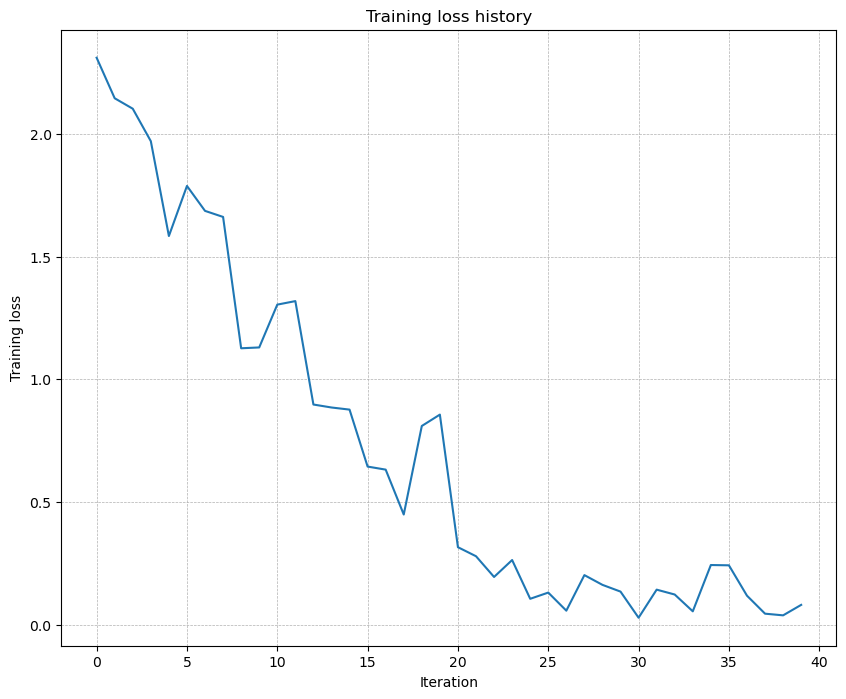

In [16]:
num_train = 50
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

weight_scale = 1e-2  # Experiment with this!
learning_rate = 1e-2  # Experiment with this!
model = FullyConnectedNet(
    [100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule="sgd",
    optim_config={"learning_rate": learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

#### Now, we try to use a bigger (five-layer network with 100 units on each layer) to overfit on 50 training examples.

(Iteration 1 / 40) loss: 3.629882
(Epoch 0 / 20) train acc: 0.220000; val_acc: 0.112000
(Epoch 1 / 20) train acc: 0.180000; val_acc: 0.124000
(Epoch 2 / 20) train acc: 0.520000; val_acc: 0.115000
(Epoch 3 / 20) train acc: 0.840000; val_acc: 0.134000
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.131000
(Epoch 5 / 20) train acc: 0.900000; val_acc: 0.119000
(Iteration 11 / 40) loss: 0.407356
(Epoch 6 / 20) train acc: 0.940000; val_acc: 0.131000
(Epoch 7 / 20) train acc: 0.940000; val_acc: 0.132000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.122000
(Epoch 9 / 20) train acc: 0.980000; val_acc: 0.128000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.139000
(Iteration 21 / 40) loss: 0.194377
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.114000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.120000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.125000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.119000
(Iteration 31 / 40) loss: 

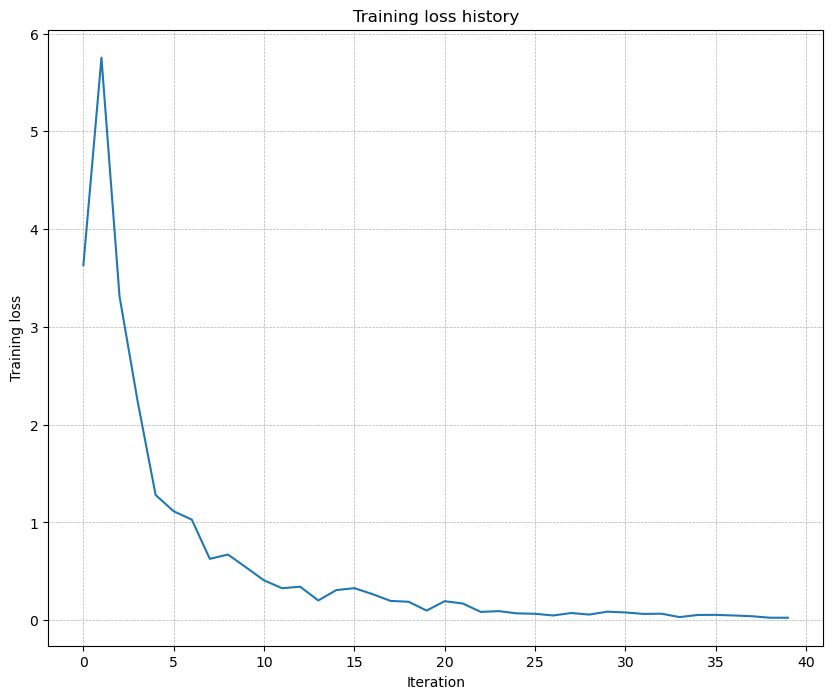

In [17]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 1e-2  # Experiment with this!
weight_scale = 5e-2   # Experiment with this!
model = FullyConnectedNet(
    [100, 100, 100, 100],
    weight_scale=weight_scale,
    dtype=np.float64
)
solver = Solver(
    model,
    small_data,
    print_every=10,
    num_epochs=20,
    batch_size=25,
    update_rule='sgd',
    optim_config={'learning_rate': learning_rate},
)
solver.train()

plt.plot(solver.loss_history)
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

### Testing Update Rules

### SGD+Momentum

In [18]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {"learning_rate": 1e-3, "velocity": v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print("next_w error: ", rel_error(next_w, expected_next_w))
print("velocity error: ", rel_error(expected_velocity, config["velocity"]))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


#### Train a six-layer network with both SGD and SGD+momentum. We should see the SGD+momentum update rule converge faster.

Running with  sgd
(Iteration 1 / 200) loss: 2.594024
(Epoch 0 / 5) train acc: 0.099000; val_acc: 0.107000
(Iteration 11 / 200) loss: 2.227823
(Iteration 21 / 200) loss: 2.166062
(Iteration 31 / 200) loss: 2.066161
(Epoch 1 / 5) train acc: 0.251000; val_acc: 0.240000
(Iteration 41 / 200) loss: 2.121407
(Iteration 51 / 200) loss: 1.933265
(Iteration 61 / 200) loss: 1.997945
(Iteration 71 / 200) loss: 1.992975
(Epoch 2 / 5) train acc: 0.315000; val_acc: 0.275000
(Iteration 81 / 200) loss: 1.795123
(Iteration 91 / 200) loss: 1.987640
(Iteration 101 / 200) loss: 1.894239
(Iteration 111 / 200) loss: 1.808687
(Epoch 3 / 5) train acc: 0.320000; val_acc: 0.290000
(Iteration 121 / 200) loss: 1.740141
(Iteration 131 / 200) loss: 2.000307
(Iteration 141 / 200) loss: 1.965916
(Iteration 151 / 200) loss: 1.934903
(Epoch 4 / 5) train acc: 0.336000; val_acc: 0.299000
(Iteration 161 / 200) loss: 1.924413
(Iteration 171 / 200) loss: 1.806650
(Iteration 181 / 200) loss: 1.906388
(Iteration 191 / 200) los

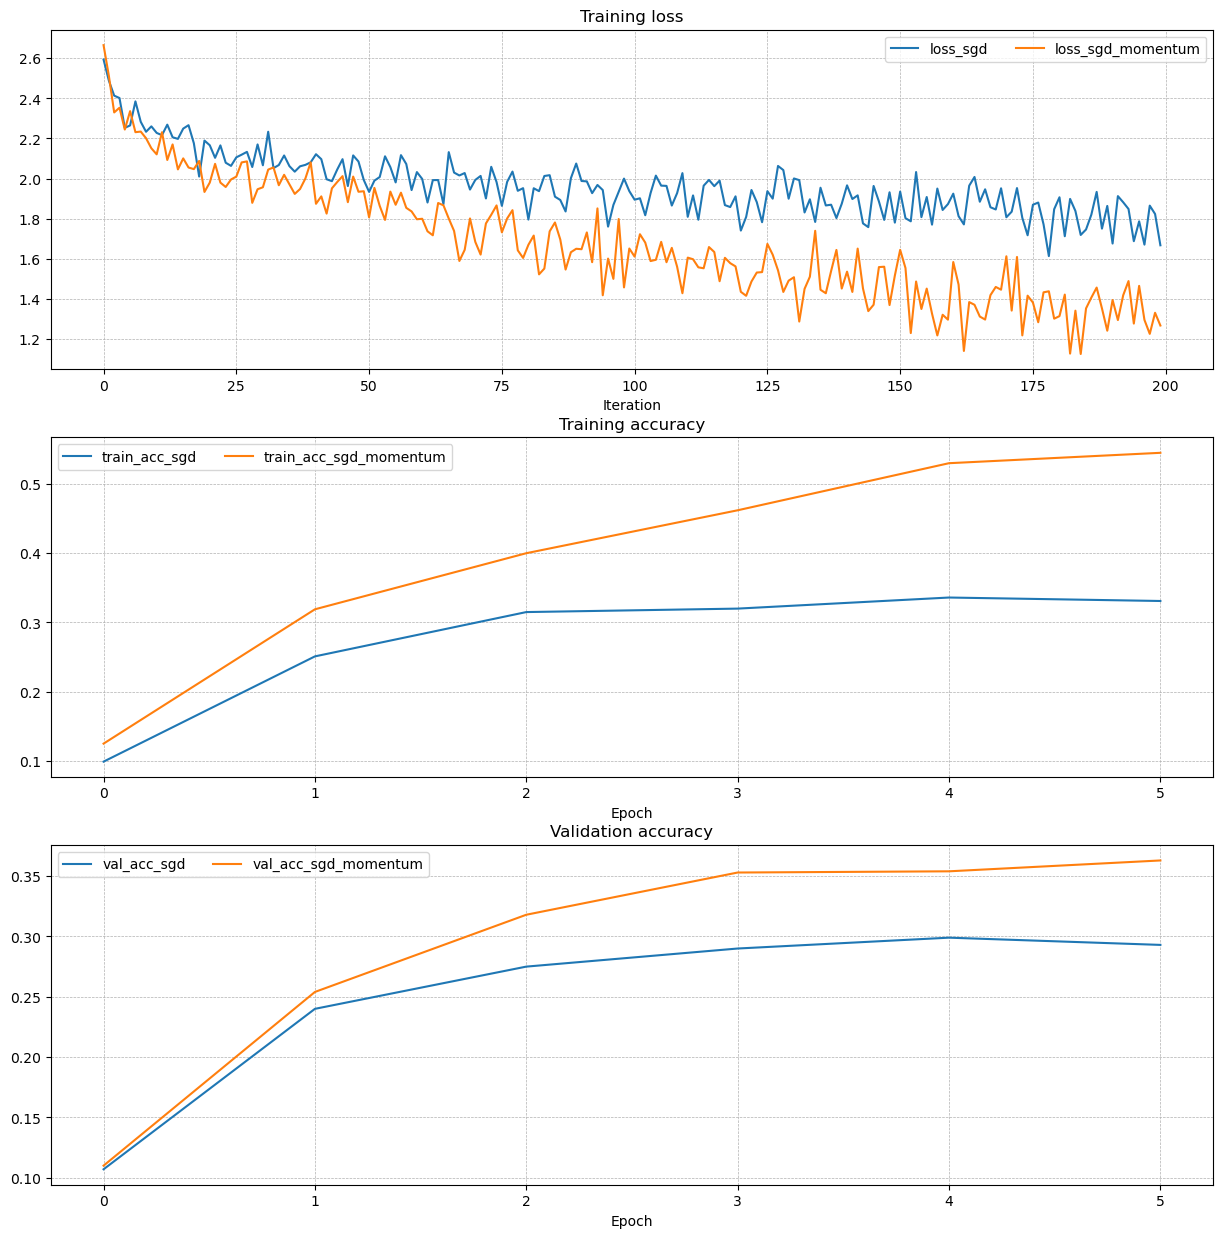

In [19]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )

    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': 5e-3},
        verbose=True,
    )
    solvers[update_rule] = solver
    solver.train()

fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"loss_{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"train_acc_{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"val_acc_{update_rule}")
    
for ax in axes:
    ax.legend(loc="best", ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

## RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

#### Test RMSProp implementation

In [21]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


#### Test Adam implementation

In [23]:
N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


#### Train a pair of deep networks using these new update rules:

Running with  adam
(Iteration 1 / 200) loss: 2.706303
(Epoch 0 / 5) train acc: 0.130000; val_acc: 0.109000
(Iteration 11 / 200) loss: 2.124432
(Iteration 21 / 200) loss: 1.946375
(Iteration 31 / 200) loss: 1.701996
(Epoch 1 / 5) train acc: 0.316000; val_acc: 0.284000
(Iteration 41 / 200) loss: 1.856919
(Iteration 51 / 200) loss: 1.583210
(Iteration 61 / 200) loss: 1.628933
(Iteration 71 / 200) loss: 1.773500
(Epoch 2 / 5) train acc: 0.427000; val_acc: 0.352000
(Iteration 81 / 200) loss: 1.599488
(Iteration 91 / 200) loss: 1.506547
(Iteration 101 / 200) loss: 1.606722
(Iteration 111 / 200) loss: 1.413842
(Epoch 3 / 5) train acc: 0.495000; val_acc: 0.376000
(Iteration 121 / 200) loss: 1.638589
(Iteration 131 / 200) loss: 1.362905
(Iteration 141 / 200) loss: 1.338286
(Iteration 151 / 200) loss: 1.411711
(Epoch 4 / 5) train acc: 0.536000; val_acc: 0.388000
(Iteration 161 / 200) loss: 1.282417
(Iteration 171 / 200) loss: 1.413267
(Iteration 181 / 200) loss: 1.388852
(Iteration 191 / 200) lo

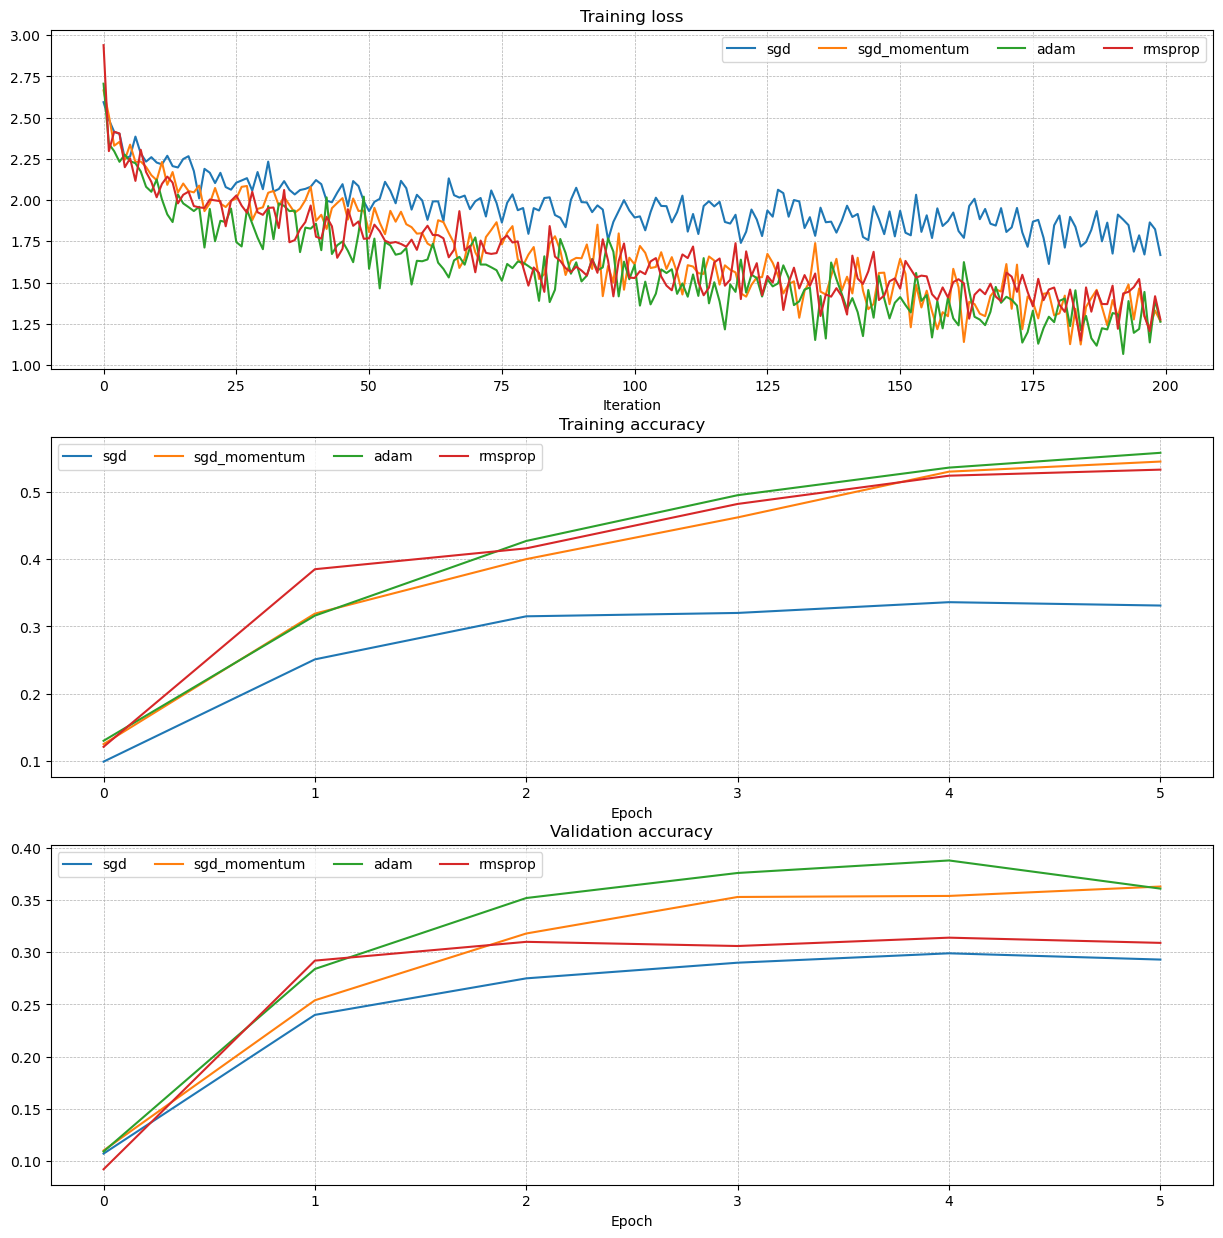

In [24]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('Running with ', update_rule)
    model = FullyConnectedNet(
        [100, 100, 100, 100, 100],
        weight_scale=5e-2
    )
    solver = Solver(
        model,
        small_data,
        num_epochs=5,
        batch_size=100,
        update_rule=update_rule,
        optim_config={'learning_rate': learning_rates[update_rule]},
        verbose=True
    )
    solvers[update_rule] = solver
    solver.train()
    print()
    
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')

for update_rule, solver in solvers.items():
    axes[0].plot(solver.loss_history, label=f"{update_rule}")
    axes[1].plot(solver.train_acc_history, label=f"{update_rule}")
    axes[2].plot(solver.val_acc_history, label=f"{update_rule}")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

# Train a Model on CIFAR-10

In [25]:
best_model = None

best_val = -1    # keep track of best validation accuracy
best_params = {} # dictionary to hold best model parameters
num_train = 500  # number of examples of training data for tests

# Generate small dataset
small_data = {
  "X_train": data["X_train"][:num_train],
  "y_train": data["y_train"][:num_train],
  "X_val": data["X_val"],
  "y_val": data["y_val"],
}

# Run 30 experiments
for i in range(30):
    lr = 10 ** np.random.uniform(-5, -3)
    ws = 10 ** np.random.uniform(-2, -1.5) # weight scale
    reg = 10 ** np.random.uniform(-3, 0)
    kr = np.random.uniform(0.7, 0.9)       # dropout keep ratio

    model = FullyConnectedNet([256, 128, 100], weight_scale=ws, reg=reg, dropout_keep_ratio=kr, normalization='batchnorm')
    
    # Create a solver using Adam as optimizer
    solver = Solver(model, small_data, num_epochs=20, batch_size=256, update_rule='adam', optim_config={'learning_rate': lr}, verbose=False)
    solver.train()  
    
    new_val = solver.best_val_acc # extract best accuracy

    # Save if validation accuracy is the best
    if new_val > best_val:
        best_val = new_val
        best_params = {'lr':lr, 'ws':ws, 'reg':reg, 'kr':kr}

    # Print the values for each chosen hyperparameter and the validation accuracy
    print(f'lr: {lr:.5f} ws: {ws:.5f}, reg: {reg:.5f}, kr: {kr:.5f}, acc: {new_val:.5f}')

print(f'Best validation accuracy using a small dataset: {best_val}')
print(f'\nTraining with best parameters...')

# Create the best model with the best parameters
best_model = FullyConnectedNet([500, 100], weight_scale=best_params['ws'], reg=best_params['reg'], dropout_keep_ratio=best_params['kr'], normalization='batchnorm')

# Create solver to train on full dataset
solver = Solver(best_model, data, num_epochs=15, batch_size=256, update_rule='adam', optim_config={'learning_rate': best_params['lr']}, verbose=False)
solver.train()

print(f'Best validation accuracy using full dataset: {solver.best_val_acc}')

lr: 0.00002 ws: 0.02921, reg: 0.01771, kr: 0.72158, acc: 0.13700
lr: 0.00092 ws: 0.03119, reg: 0.00349, kr: 0.80891, acc: 0.27100
lr: 0.00028 ws: 0.01705, reg: 0.00175, kr: 0.88505, acc: 0.24600
lr: 0.00022 ws: 0.01143, reg: 0.50425, kr: 0.85553, acc: 0.15100
lr: 0.00006 ws: 0.01387, reg: 0.08592, kr: 0.81717, acc: 0.15400
lr: 0.00003 ws: 0.02380, reg: 0.00967, kr: 0.77238, acc: 0.13100
lr: 0.00002 ws: 0.01247, reg: 0.00864, kr: 0.80447, acc: 0.16400
lr: 0.00012 ws: 0.02605, reg: 0.00281, kr: 0.71841, acc: 0.21600
lr: 0.00003 ws: 0.01197, reg: 0.00581, kr: 0.71500, acc: 0.17600
lr: 0.00028 ws: 0.01335, reg: 0.15580, kr: 0.73393, acc: 0.17600
lr: 0.00063 ws: 0.02197, reg: 0.01923, kr: 0.77671, acc: 0.26700
lr: 0.00035 ws: 0.01034, reg: 0.45375, kr: 0.82752, acc: 0.14100
lr: 0.00002 ws: 0.02794, reg: 0.04095, kr: 0.83349, acc: 0.11600
lr: 0.00003 ws: 0.02106, reg: 0.00270, kr: 0.79131, acc: 0.15600
lr: 0.00074 ws: 0.02610, reg: 0.00201, kr: 0.88024, acc: 0.27300
lr: 0.00039 ws: 0.02716, 

# Test Best Model

In [26]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.544
Test set accuracy:  0.537
